In [44]:
from src import create_generator

K = 5
N_DOC = 1000
N_QUERY = 10000
# generator = create_generator("real", n_doc=800, lam=0.8, path="../data")
generator = create_generator("synthetic", n_doc=N_DOC, n_query=N_QUERY, lam=0.5)

rel_mat, _ = generator.generate_rel_mat()
expo = generator.exam_func(K=K)

# min-max normalization
rel_mat = (rel_mat - rel_mat.min()) / (rel_mat.max() - rel_mat.min())

In [45]:
import pandas as pd


def scaling(x: pd.DataFrame) -> pd.DataFrame:
    return (x - x.min()) / (x.max() - x.min())

In [46]:
import random

import numpy as np


def greedy_custering(n_sample_query: int = 500, n_sample_sup: int = 50, query_priority: int = 2):
    unused_query = list(range(rel_mat.shape[0]))
    unused_sup = list(range(rel_mat.shape[1]))

    blocks = []
    turn = 0
    while (len(unused_sup) != 0) or (len(unused_query) != 0):
        if turn % query_priority == 0:
            # ランダムな提供者を抽出
            sample_sup = random.sample(unused_sup, min(n_sample_sup, len(unused_sup)))

            # 提供者が好む上位n_sample_queryの利用者を抽出
            n_sample_query_ = min(n_sample_query, len(unused_query))
            if n_sample_query_ == len(unused_query):
                topk_query = unused_query
            else:
                top_k_idx = np.argpartition(
                    -rel_mat[:, sample_sup][unused_query].sum(axis=1), n_sample_query_
                )[:n_sample_query_]
                topk_query = np.array(unused_query)[top_k_idx]
            blocks.append((topk_query, sample_sup))

            # 選択した利用者提供者を削除
            unused_query = [x for x in unused_query if x not in topk_query]
            unused_sup = [x for x in unused_sup if x not in sample_sup]
        else:
            # ランダムな利用者を抽出
            sample_query = random.sample(unused_query, min(n_sample_query, len(unused_query)))

            # 利用者が好む上位n_sample_supの提供者を抽出
            n_sample_sup_ = min(len(unused_sup) - 1, n_sample_sup)
            if n_sample_sup_ == len(unused_sup):
                topk_sup = unused_sup
            else:
                top_k_idx = np.argpartition(
                    -rel_mat[sample_query][:, unused_sup].sum(axis=0), n_sample_sup_
                )[:n_sample_sup_]
                topk_sup = np.array(unused_sup)[top_k_idx]
            blocks.append((sample_query, topk_sup))

            # 選択した利用者提供者を削除
            unused_query = [x for x in unused_query if x not in sample_query]
            unused_sup = [x for x in unused_sup if x not in topk_sup]

        turn += 1

    query2label = {query_i: k for k, (query, _) in enumerate(blocks) for query_i in query}
    sup2label = {sup_i: k for k, (_, sup) in enumerate(blocks) for sup_i in sup}

    row_labels = np.array([k for _, k in sorted(query2label.items(), key=lambda x: x[0])])
    col_labels = np.array([k for _, k in sorted(sup2label.items(), key=lambda x: x[0])])

    return blocks, row_labels, col_labels

In [47]:
def random_clustering(k: int):
    if k == 1:
        return (
            [(np.arange(rel_mat.shape[0]), np.arange(rel_mat.shape[1]))],
            np.zeros(rel_mat.shape[0]),
            np.zeros(rel_mat.shape[1]),
        )
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=k, shuffle=True)

    row_labels = np.zeros(rel_mat.shape[0])
    for i, (_, test_index) in enumerate(kf.split(row_labels)):
        row_labels[test_index] = i

    col_labels = np.zeros(rel_mat.shape[1])
    for i, (_, test_index) in enumerate(kf.split(col_labels)):
        col_labels[test_index] = i

    blocks = []
    for i in range(k):
        blocks.append((np.where(row_labels == i)[0], np.where(col_labels == i)[0]))

    return blocks, row_labels, col_labels

In [64]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import SpectralCoclustering
from tqdm import tqdm
import copy

from src import create_optimizer, evaluate_pi

A = rel_mat
optimizer = create_optimizer(
    "ot_nsw", alpha=0.0, eps=1.0, max_iter=100, lr=0.5, device="cuda", use_amp=False, tol=0.01
)
results = []
# Greedy Clusteringを適応
# cluster毎に求解
for k in tqdm([1, 2, 4, 5, 10, 15, 20]):
    # # random clustering
    # t0 = time.time()
    # n_sample_query = N_QUERY // k
    # n_sample_sup = N_DOC // k
    # blocks, row_labels, col_labels = random_clustering(k=k)
    # k = len(blocks)
    # pi = np.zeros((A.shape[0], A.shape[1], K))
    # clustering_time = time.time() - t0
    # min_optim = 1e5
    # for i in range(k):
    #     t0 = time.time()
    #     row, col = blocks[i]
    #     if len(row) == 0 or len(col) == 0:
    #         continue
    #     rel_mat_block = rel_mat[row][:, col]
    #     pi_block = optimizer.solve(rel_mat_block, expo)
    #     pi[np.ix_(row, col, np.arange(K))] = pi_block
    #     optim_time = time.time() - t0
    #     min_optim = min(min_optim, optim_time)

    # exec_time = clustering_time + min_optim
    # result_k = evaluate_pi(pi, rel_mat, expo)
    # result_k["k"] = k
    # result_k["method"] = "random"
    # result_k["exec_time"] = exec_time
    # # 行列の要素数に対するブロックの要素数の割合を計算
    # n_rows, n_cols = A.shape
    # block_sizes = 0
    # for i in range(k):
    #     row, col = blocks[i]
    #     block_sizes += len(row) * len(col)
    # block_ratio = 100 * block_sizes / (n_rows * n_cols)
    # result_k["block_ratio"] = block_ratio
    # results.append(result_k)

    # greedy clustering
    t0 = time.time()
    n_sample_query = N_QUERY // k
    n_sample_sup = N_DOC // k
    blocks, row_labels, col_labels = greedy_custering(
        n_sample_query, n_sample_sup, query_priority=2
    )
    k = len(blocks)
    pi = np.zeros((A.shape[0], A.shape[1], K))
    clustering_time = time.time() - t0
    min_optim = 1e5
    for i in range(k):
        t0 = time.time()
        row, col = blocks[i]
        if len(row) == 0 or len(col) == 0:
            continue
        rel_mat_block = rel_mat[row][:, col]
        pi_block = optimizer.solve(rel_mat_block, expo)
        pi[np.ix_(row, col, np.arange(K))] = pi_block
        optim_time = time.time() - t0
        min_optim = min(min_optim, optim_time)

    exec_time = clustering_time + min_optim
    result_k = evaluate_pi(pi, rel_mat, expo)
    result_k["k"] = k
    result_k["method"] = "greedy"
    result_k["exec_time"] = exec_time

    # 行列の要素数に対するブロックの要素数の割合を計算
    n_rows, n_cols = A.shape
    block_sizes = 0
    for i in range(k):
        row, col = blocks[i]
        block_sizes += len(row) * len(col)
    block_ratio = 100 * block_sizes / (n_rows * n_cols)
    result_k["block_ratio"] = block_ratio
    results.append(result_k)

    # spectral coclustering
    if k == 1:
        result_k_cp = copy.deepcopy(result_k)
        result_k_cp["method"] = "spectral_coclustering"
        results.append(result_k_cp)
        continue
    t0 = time.time()
    clustering = SpectralCoclustering(n_clusters=k)
    clustering.fit(A)
    clustering_time = time.time() - t0
    # cluster毎に求解
    pi = np.zeros((A.shape[0], A.shape[1], K))
    min_optim = 1e5
    for i in range(k):
        t0 = time.time()
        row, col = clustering.get_indices(i)
        rel_mat_block = rel_mat[row][:, col]
        pi_block = optimizer.solve(rel_mat_block, expo)
        pi[np.ix_(row, col, np.arange(K))] = pi_block
        optim_time = time.time() - t0
        min_optim = min(min_optim, optim_time)
    exec_time = clustering_time + min_optim
    result_k = evaluate_pi(pi, rel_mat, expo)
    result_k["k"] = k
    result_k["method"] = "spectral_coclustering"
    result_k["exec_time"] = exec_time

    # 行列の要素数に対するブロックの要素数の割合を計算
    n_rows, n_cols = A.shape
    block_sizes = 0
    for i in range(k):
        row, col = clustering.get_indices(i)
        block_sizes += len(row) * len(col)
    block_ratio = 100 * block_sizes / (n_rows * n_cols)
    result_k["block_ratio"] = block_ratio
    results.append(result_k)

    # ラベルに基づいて行列の順序を入れ替え
    # col_indices = np.argsort(col_labels)
    # row_indices = np.argsort(row_labels)
    # A_sorted = A[row_indices][:, col_indices]

    # クラスタの境界を計算
    # def get_cluster_boundaries(labels):
    #     boundaries = []
    #     unique_labels = np.unique(labels)
    #     for label in unique_labels:
    #         indices = np.where(labels == label)[0]
    #         boundaries.append((indices[0], indices[-1] + 1))
    #     return boundaries

    # row_boundaries = get_cluster_boundaries(row_labels[row_indices])
    # col_boundaries = get_cluster_boundaries(col_labels[col_indices])

    # 結果をプロット
    # ax: plt.Axes
    # fig, ax = plt.subplots()
    # cmap = "viridis"
    # # sns.heatmap(A, ax=ax[0], cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
    # # ax[0].set_title("Original Matrix")
    # sns.heatmap(A_sorted, ax=ax, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
    # ax.set_title("Sorted Matrix")

    # # grid off
    # ax.grid(False)
    # ax.set_xlabel("Items")
    # ax.set_ylabel("Users")

    # # 対角ブロックの境界をプロット
    # for (row_start, row_end), (col_start, col_end) in zip(row_boundaries, col_boundaries):
    #     ax.hlines(
    #         [row_start, row_end], xmin=col_start, xmax=col_end, colors="red", label="cluster"
    #     )
    #     ax.vlines(
    #         [col_start, col_end], ymin=row_start, ymax=row_end, colors="red", label="cluster"
    #     )

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:52<00:00,  7.55s/it]


In [68]:
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")

METRICS_MAP = {
    "exec_time": "CPU time (s)",
    "exec_time_rate": "実行時間の比率",
    "user_util": "User utility",
    "mean_max_envy": "Mean max envy",
    "pct_item_util_better": "Items better off (%)",
    "pct_item_util_worse": "Items worse off (%)",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    "greedy": "MaxRele",
    "expo_fair": "ExpFair",
    "nsw": "NSW",
    "greedy_nsw": "NSW(Greedy)",
    "ot_nsw": "NSW(Algo1)",
    "pgd_nsw": "NSW (射影勾配法) ",
}
METHOD_TO_COLOR = {
    "MaxRele": "#E24A33",
    "ExpFair": "#FBC15E",
    "ExpFair(Mosek)": "#FBC15E",
    "ExpFair(SCS)": "#FBC15E",
    "NSW(Greedy)": "#777777",
    "NSW (既存) ": "#988ED5",
    "NSW(Mosek)": "#988ED5",
    "NSW(SCS)": "#988ED5",
    "NSW(Algo1)": "#348ABD",
    "NSW(Algo1+GPU)": "#348ABD",
    "NSW (射影勾配法) ": "#8EBA42",
}
METHOD_TO_LINESTYLE = {
    "MaxRele": "-",
    "ExpFair": "-",
    "ExpFair(Mosek)": "-",
    "閲覧公平 (SCS) ": "-",
    "NSW(Greedy)": "-",
    "NSW (既存) ": "-",
    "NSW(Mosek)": "-",
    "NSW (SCS) ": "-",
    "NSW(Algo1)": "--",
    "NSW(Algo1+GPU)": "-",
    "NSW (射影勾配法) ": "-",
}


def plot_fairness_and_user_utils(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    errorbar: Optional[tuple[str, float]] = None,
    metrics: list[str] = [
        "exec_time",
        "user_util",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
):
    ncols = len(metrics)
    figsize_0 = 45 / 4
    fig, axes = plt.subplots(
        ncols=2, nrows=2, figsize=(figsize_0 * 2.5, figsize_0 * 2), tight_layout=True
    )
    axes: list[plt.Axes] = np.ravel(axes).tolist()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(
            result,
            x=x,
            y=metric,
            ax=ax,
            marker="o",
            markersize=15,
            markers=True,
            linewidth=8,
            legend=legend,
            hue="method",
            errorbar=errorbar,
        )

        if metric in [
            "pct_item_util_better",
            "pct_item_util_worse",
        ]:
            ax.set_ylim(-5, 105)
        # elif metric == "exec_time":
        #     ax.set_yscale("log")
        #     ax.set_ylim(bottom=5e-1, top=5e3)

        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel(xlabel, fontsize=42)
        ax.set_xlim(0, 100)
        ax.legend(fontsize=35)
        ax.tick_params(axis="both", labelsize=35)

In [69]:
import pandas as pd

result_df = pd.DataFrame(results)
# result_df["query_priority"] = result_df["query_priority"].astype(str)
result_df["reduction_rate"] = 100 - result_df["block_ratio"]

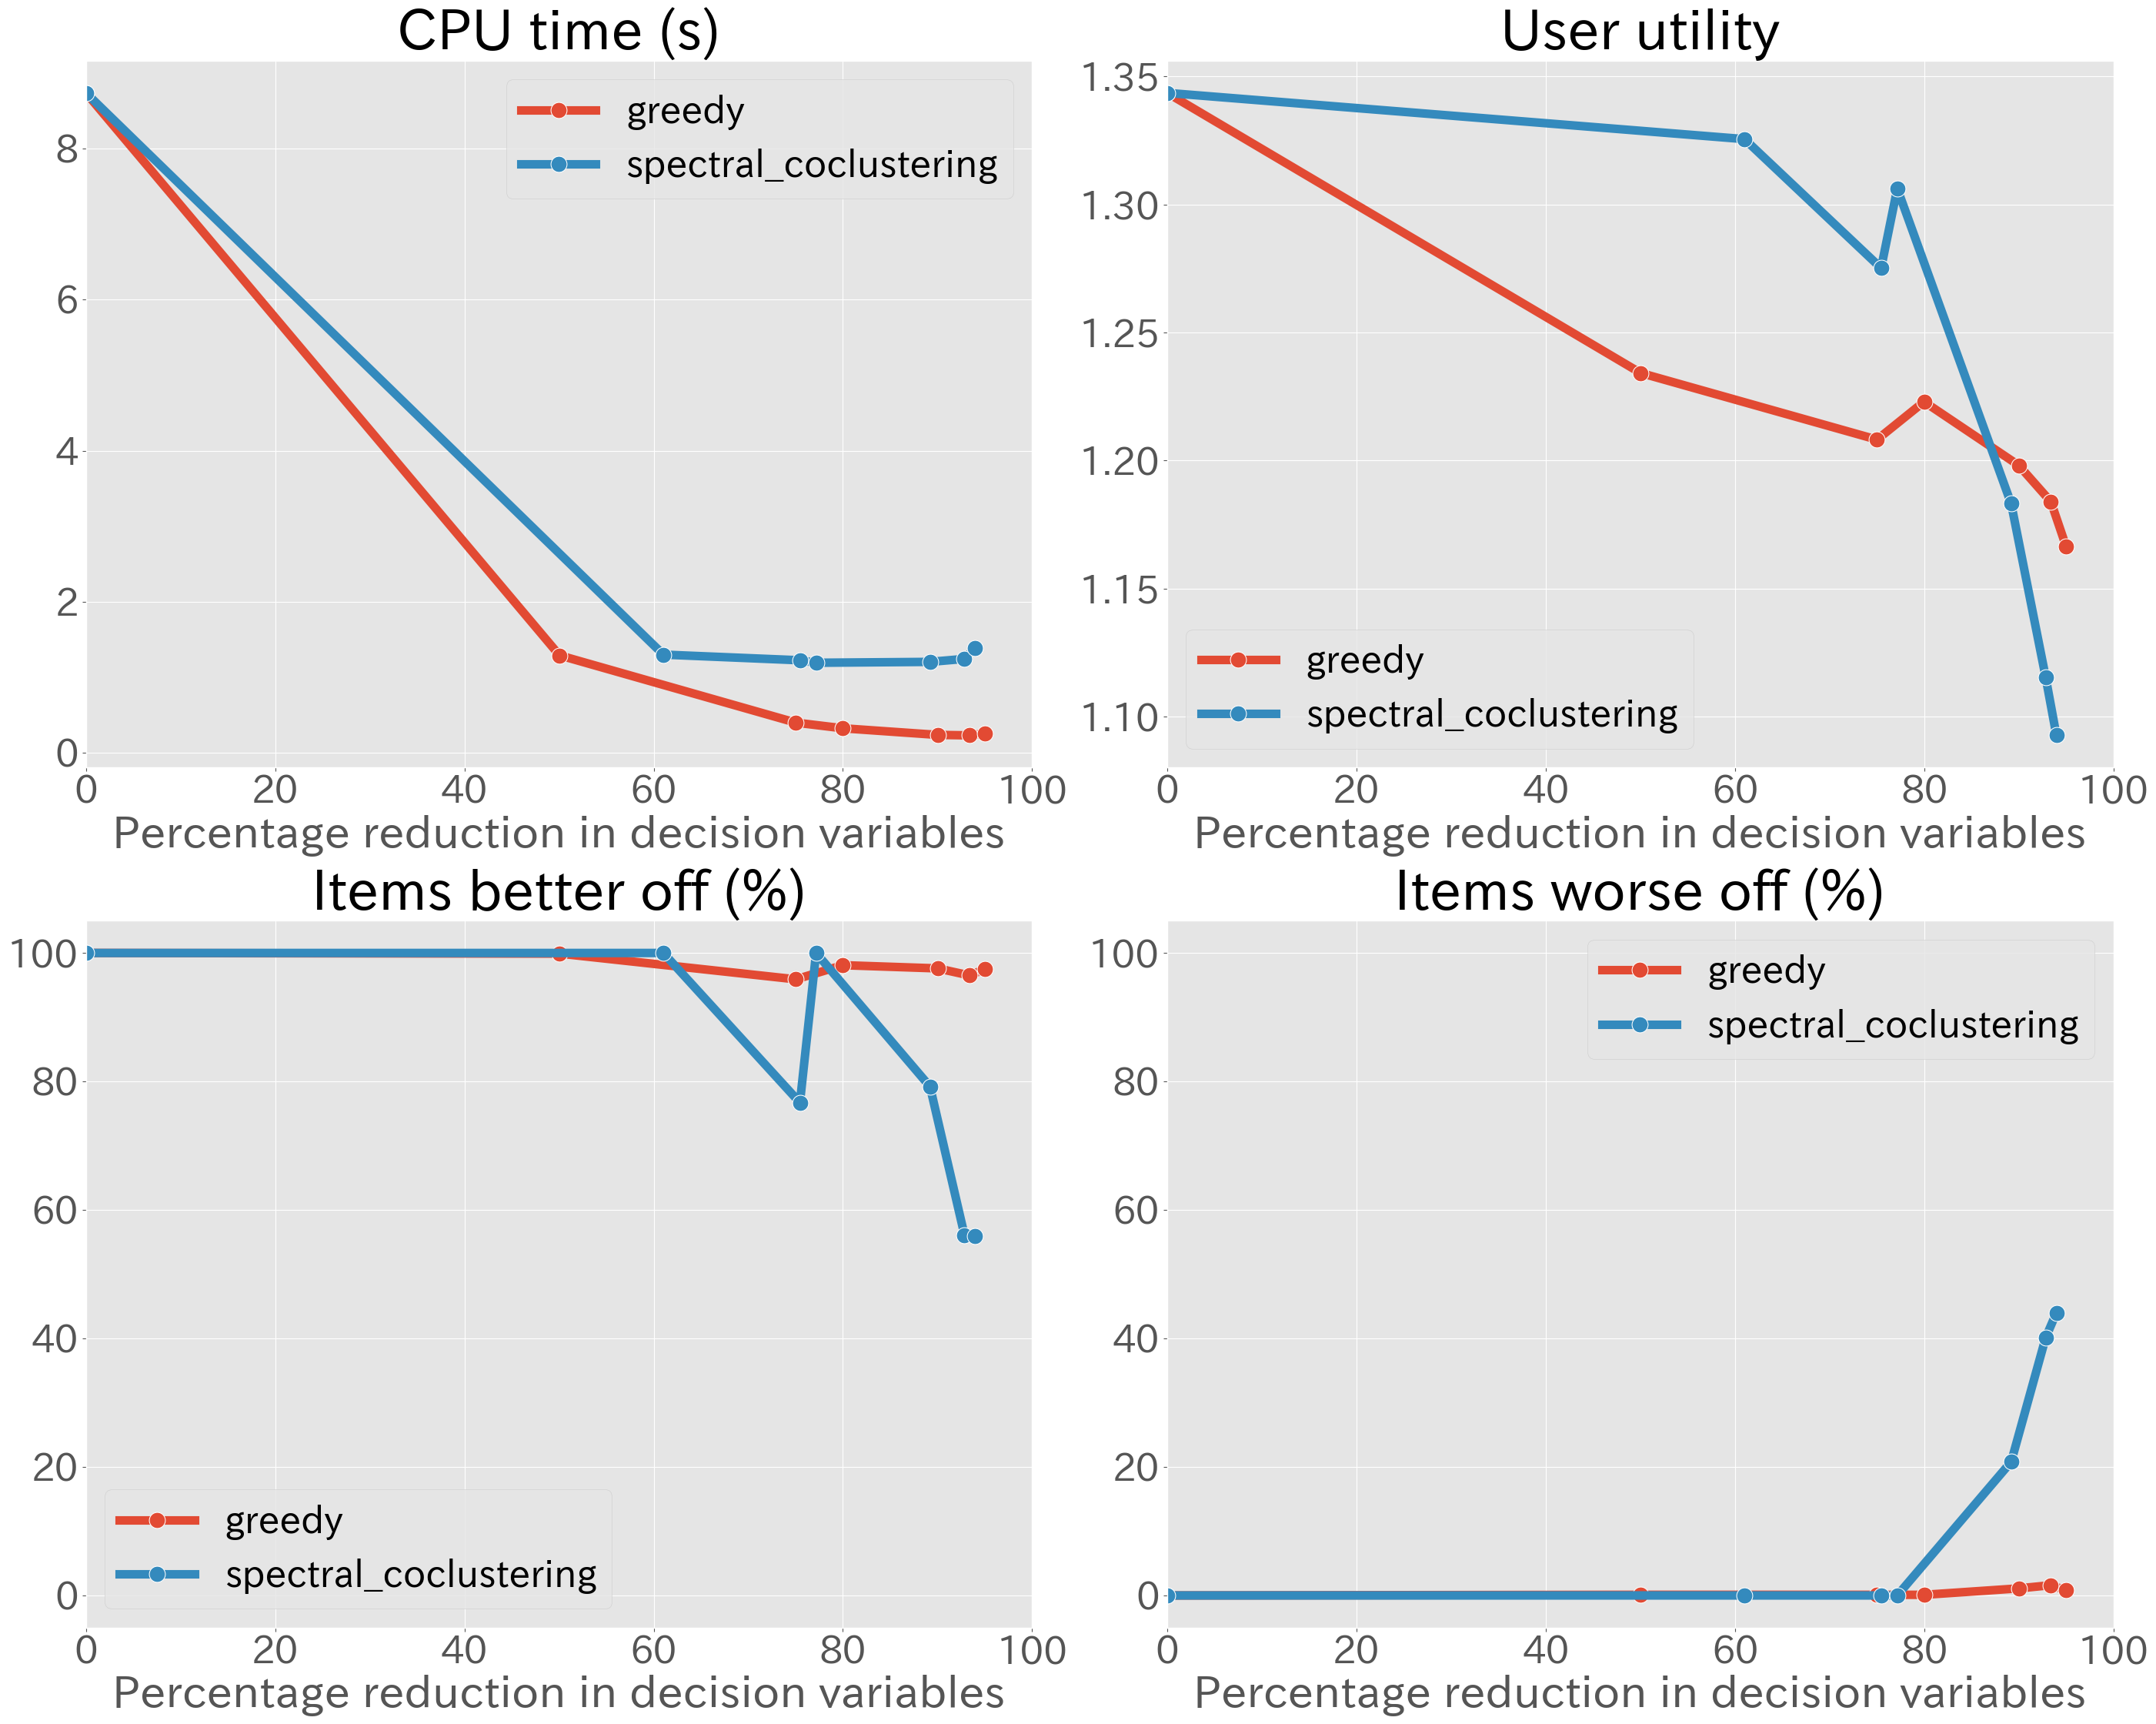

In [70]:
plot_fairness_and_user_utils(
    result_df, x="reduction_rate", xlabel="Percentage reduction in decision variables"
)